**Convolutional Neural Network (CNN) basierend auf die YOLO-Architektur zur Erkennung von deutschen Verkehrszeichen in Echtzeit mit dem GTSRB-Dataset**

Autoren: Laieb Ahmad, Enes Bayar, Mehmet Akif Onur & Mert-Can Öksuz
<br>
Datum: 19.08.2024
<br>
Modul: KI-DL/ML
<br>
Dozent: Prof. Dr. Stephan Schneider

## **Befehle zum Installieren/Upgraden von Packages**
Hiert führen wir die Installation (und nach Bedarf ein Upgrade) wichtiger Python-Pakete durch, die für unser Projekt benötigt werden. Wir verwenden die Bash-Magie `%%bash`, um mehrere `pip install`-Befehle in einer einzigen Zelle auszuführen. Dadurch wird die Effizienz erhöht und der Code übersichtlicher gestaltet.

Die folgenden Pakete werden aktualisiert:
- **Numpy**: Eine Bibliothek für numerische Berechnungen und Unterstützung von Arrays.
- **Pandas**: Eine leistungsstarke Bibliothek zur Datenmanipulation und -analyse.
- **Scikit-learn**: Ein Framework für maschinelles Lernen mit zahlreichen Algorithmen und Werkzeugen.
- **Scikit-image**: Eine Sammlung von Algorithmen zur Bildverarbeitung.
- **Pillow**: Eine Bibliothek zur Bildbearbeitung und -manipulation.
- **Imbalanced-learn**: Eine Bibliothek zur Behandlung von unausgewogenen Datensätzen im maschinellen Lernen.
- **Statsmodels**: Eine Bibliothek für statistische Modelle und Hypothesentests.
- **Matplotlib**: Ein Plotting-Toolkit zur Datenvisualisierung.
- **Seaborn**: Eine auf Matplotlib basierende Bibliothek zur statistischen Datenvisualisierung.
- **TensorFlow**: Ein Framework für maschinelles Lernen und Deep Learning.
- **Ultralytics**: Eine Bibliothek, die das YOLO-Framework für die Objekt- und Verkehrszeichenerkennung bereitstellt.

Durch die Verwendung dieser Bash-Zelle stellen wir sicher, dass alle erforderlichen Pakete auf dem neuesten Stand sind, um optimale Leistung und Kompatibilität während der Entwicklung zu gewährleisten.


In [ ]:
%%bash 
pip install wandb --upgrade
pip install numpy --upgrade
pip install pandas --upgrade
pip install scikit-learn --upgrade
pip install scikit-image --upgrade
pip install pillow --upgrade
pip install imbalanced-learn --upgrade
pip install statsmodels --upgrade
pip install matplotlib --upgrade
pip install seaborn --upgrade
pip install tensorflow --upgrade
pip install ultralytics --upgrade
pip install pyyaml --upgrade
pip install kaggle --upgrade

## **Laden von Packages**
In diesem Abschnitt importieren wir die erforderlichen Bibliotheken, die für die Entwicklung und Ausführung unseres YOLOv5-Projekts notwendig sind.

- **`from ultralytics import YOLO`**: Importiert das YOLO-Modul von Ultralytics, das für die Objekt- und Verkehrszeichenerkennung verwendet wird.
- **`import os`**: Ermöglicht den Zugriff auf Funktionen zur Interaktion mit dem Betriebssystem, wie das Verwalten von Dateipfaden und Verzeichnissen.
- **`import numpy as np`**: Importiert die Numpy-Bibliothek, die grundlegende Funktionen für numerische Berechnungen und Arrays bereitstellt.
- **`import pandas as pd`**: Importiert Pandas, das für die Datenmanipulation und -analyse verwendet wird, insbesondere für die Arbeit mit DataFrames.
- **`import cv2`**: Importiert OpenCV, eine Bibliothek für Computer Vision, die Funktionen zur Bild- und Videoverarbeitung bereitstellt.
- **`import shutil`**: Ermöglicht die Durchführung von Datei- und Verzeichnisoperationen, wie das Kopieren und Verschieben von Dateien.
- **`import matplotlib`**: Importiert Matplotlib, eine Bibliothek zur Datenvisualisierung, die häufig zur Erstellung von Diagrammen und Grafiken verwendet wird.
- **`import csv`**: Importiert die CSV-Bibliothek, die das Arbeiten mit CSV-Dateien zur Datenspeicherung und -verarbeitung erleichtert.
- **`import torch`**: Importiert PyTorch, ein Framework für maschinelles Lernen, das für die Implementierung und das Training von Deep-Learning-Modellen verwendet wird.

Durch diese Importe stellen wir sicher, dass wir alle notwendigen Funktionen und Werkzeuge zur Verfügung haben, um unser Projekt erfolgreich umzusetzen.


In [1]:
from ultralytics import YOLO
from helfer_funktionen import datensatz_entpacken_importieren, get_filenames, read_images, images_to_array, plot_images_with_annotations, write_yaml_to_file, plot_class_distribution
from PIL import Image
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import csv
import torch
import wandb
import yaml

## **Übersicht der Versionen von den genutzten Packages**
In diesem Abschnitt überprüfen wir die installierten Versionen wichtiger Pakete, die in unserem Projekt verwendet werden. Wir nutzen `print()`-Befehle, um die Versionen der Pakete Numpy, Pandas, OpenCV, Matplotlib, CSV und PyTorch anzuzeigen. Dies ermöglicht uns, sicherzustellen, dass die richtigen Versionen installiert sind und die Kompatibilität zwischen den Bibliotheken gegeben ist.


In [2]:
print("Package 'Numpy':",np.__version__)
print("Package 'Pandas':",pd.__version__)
print("Package 'OpenCV':",cv2.__version__)
print("Package 'CSV':",csv.__version__)
print("Package 'PyTorch':",torch.__version__)
print("Package 'WandB':",wandb.__version__)

Package 'Numpy': 1.26.4
Package 'Pandas': 2.2.3
Package 'OpenCV': 4.10.0
Package 'CSV': 1.0
Package 'PyTorch': 2.4.1+cpu
Package 'WandB': 0.18.3


## **Installieren von Yolov5**
In diesem Abschnitt klonen wir das YOLOv5-Repository von GitHub, um auf den Quellcode und die Modelle zuzugreifen. Zuerst verwenden wir den Befehl `!git clone https://github.com/ultralytics/yolov5`, um das Repository auf unser lokales System herunterzuladen. Anschließend wechseln wir mit `%cd yolov5` in das Verzeichnis des geklonten Projekts, um dort weitere Schritte auszuführen. Schließlich installieren wir mit `%pip install -r requirements.txt` alle erforderlichen Abhängigkeiten, die für den Betrieb des YOLOv5-Modells notwendig sind.


In [ ]:
!git clone https://github.com/ultralytics/yolov5

%%bash
cd yolov5
pip install -r requirements.txt

## **Importieren des Datensatzes**
Der Datensatz wird mit der Funktion `datensatz_entpacken_importieren()` importiert, die in einer separaten Datei namens `helfer_funktionen.py` implementiert ist. Diese Funktion nutzt die Kaggle-API, um den gewünschten Datensatz direkt von Kaggle herunterzuladen, zu entpacken und im Projektverzeichnis abzulegen.

In [ ]:
datensatz_entpacken_importieren()

Datensatz valentynsichkar/yolo-v5-format-of-the-traffic-signs-dataset wird heruntergeladen....
Dataset URL: https://www.kaggle.com/datasets/valentynsichkar/yolo-v5-format-of-the-traffic-signs-dataset
Verzeichnis 'ts43classes' wird entpackt.... 
Verzeichnis 'ts43classes' erfolgreich nach ./data verschoben.
Import abgeschlossen.


## **Übersicht über den Datensatz im Verhältnis der Klassen zur der Anzahl der Bilder in den jeweiligen Klassen**

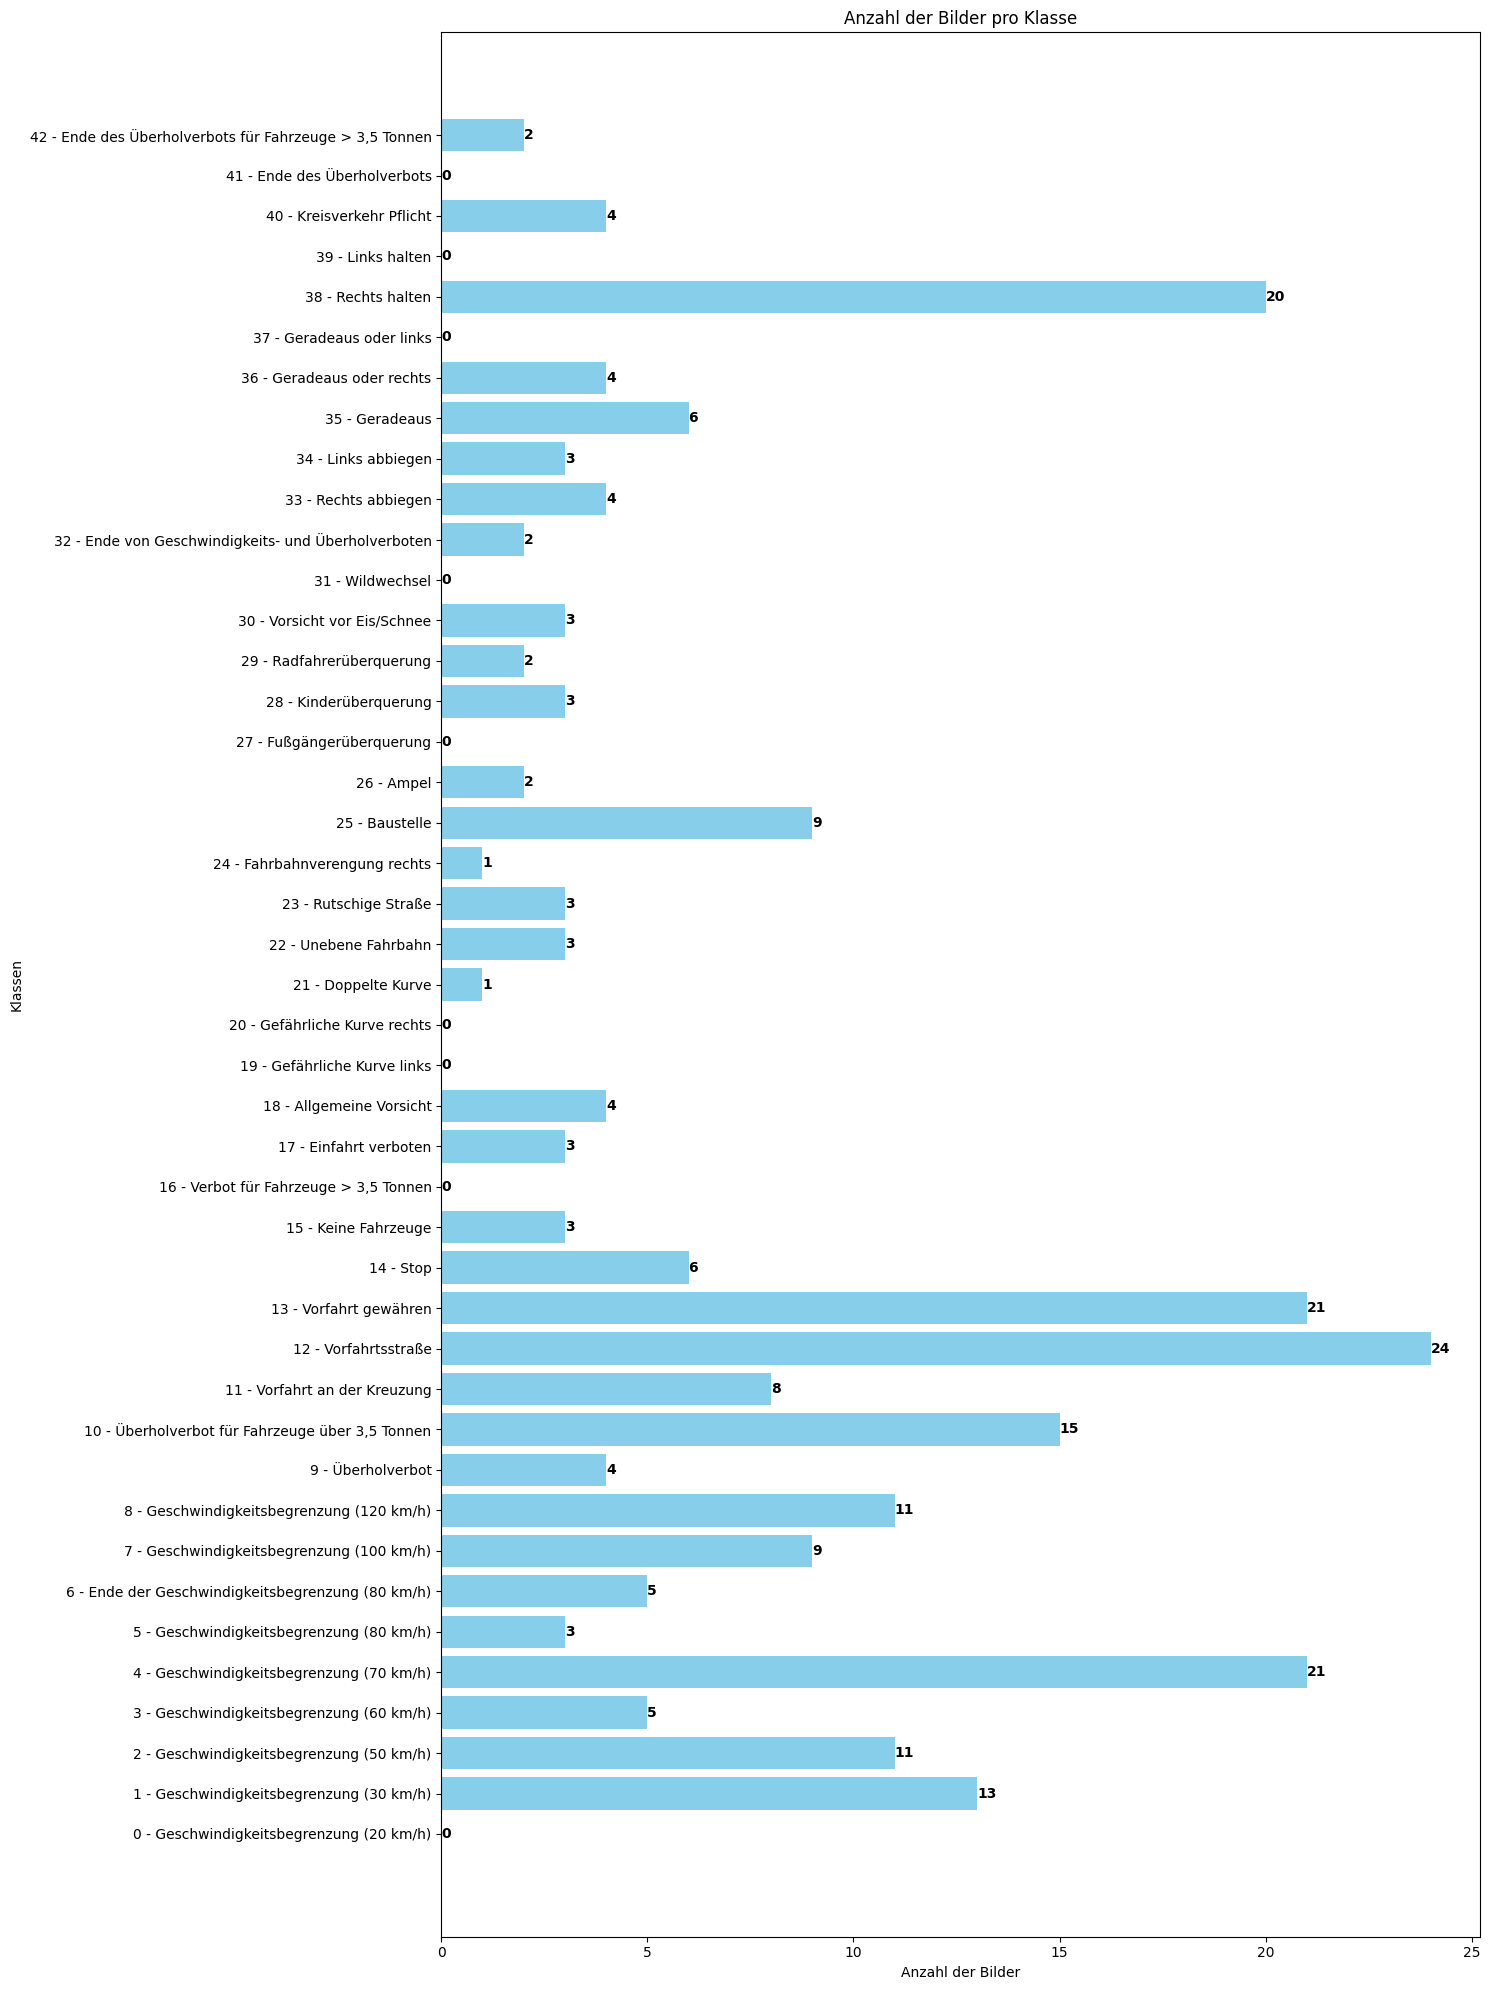

In [5]:
label_path = "G:/Meine Ablage/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/labels/validation"
class_names = [
    "Geschwindigkeitsbegrenzung (20 km/h)",
    "Geschwindigkeitsbegrenzung (30 km/h)",
    "Geschwindigkeitsbegrenzung (50 km/h)",
    "Geschwindigkeitsbegrenzung (60 km/h)",
    "Geschwindigkeitsbegrenzung (70 km/h)",
    "Geschwindigkeitsbegrenzung (80 km/h)",
    "Ende der Geschwindigkeitsbegrenzung (80 km/h)",
    "Geschwindigkeitsbegrenzung (100 km/h)",
    "Geschwindigkeitsbegrenzung (120 km/h)",
    "Überholverbot",
    "Überholverbot für Fahrzeuge über 3,5 Tonnen",
    "Vorfahrt an der Kreuzung",
    "Vorfahrtsstraße",
    "Vorfahrt gewähren",
    "Stop",
    "Keine Fahrzeuge",
    "Verbot für Fahrzeuge > 3,5 Tonnen",
    "Einfahrt verboten",
    "Allgemeine Vorsicht",
    "Gefährliche Kurve links",
    "Gefährliche Kurve rechts",
    "Doppelte Kurve",
    "Unebene Fahrbahn",
    "Rutschige Straße",
    "Fahrbahnverengung rechts",
    "Baustelle",
    "Ampel",
    "Fußgängerüberquerung",
    "Kinderüberquerung",
    "Radfahrerüberquerung",
    "Vorsicht vor Eis/Schnee",
    "Wildwechsel",
    "Ende von Geschwindigkeits- und Überholverboten",
    "Rechts abbiegen",
    "Links abbiegen",
    "Geradeaus",
    "Geradeaus oder rechts",
    "Geradeaus oder links",
    "Rechts halten",
    "Links halten",
    "Kreisverkehr Pflicht",
    "Ende des Überholverbots",
    "Ende des Überholverbots für Fahrzeuge > 3,5 Tonnen"
]
output_path = 'G:/Meine Ablage/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data'

plot_class_distribution(label_path, class_names, output_path)

## **Übersicht über die Auflösungen der Bilder in dem Datensatz**

In [62]:
# Import Packages
import pandas as pd
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np

# Get the Image Resolutions
imgs = [img.name for img in Path(r"G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\data\images\train").iterdir() if img.suffix == ".jpg"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(Path(r"G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\data\images\train") / f)

# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index()
img_meta_df.columns = ['FileName', 'Size']
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

Total Nr of Images in the dataset: 678


,FileName,Size,Width,Height,Aspect Ratio
0,00002.jpg,"(1360, 800)",1360,800,1.7
1,00003.jpg,"(1360, 800)",1360,800,1.7
2,00004.jpg,"(1360, 800)",1360,800,1.7
3,00005.jpg,"(1360, 800)",1360,800,1.7
4,00006.jpg,"(1360, 800)",1360,800,1.7


## **Laden und Anzeigen von Trainingsbildern**

1. **Bezug zu Dateien herstellen**: Definiert den Pfad zum Verzeichnis der Trainingsbilder und lädt die Bilddateinamen in die Liste `image_names`.

2. **Parameter für das Laden der Bilder**: Legt die gewünschte Bildgröße (`height` und `width` von 200 Pixeln) und die Anzahl der Farbkanäle (RGB) fest. Lädt die Bilder mit diesen Parametern in die Variable `images`.

3. **Bilder in ein Array umwandeln**: Wandelt die geladenen Bilder in ein Array (`aimages`) um und gibt die Form des Arrays aus.

4. **Bilder plotten**: Zeigt bis zu 8 Bilder aus dem Array in einem 3x4-Raster an. Die Bilder werden in einem 8x8 Zoll großen Plot angezeigt.

Form des Bilder-Arrays: (678, 200, 200, 3)


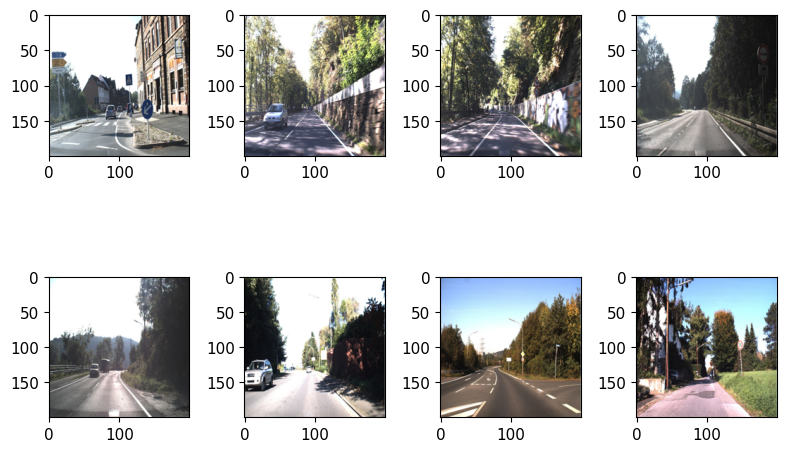

In [55]:
%matplotlib inline
filepath = r"G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\data\images\train"
image_names = get_filenames(filepath)

input_shape = {
    "height": 200,
    "width": 200,
    "channels": 3
}
images = read_images(image_names, height=input_shape["height"], width=input_shape["width"])

aimages = images_to_array(images)
print(f'Form des Bilder-Arrays: {aimages.shape}') # Struktur des Arrays: (Anzahl der Bilder, Höhe, Breite, Farbkanal)

fig = plt.figure(figsize=(8, 8))
rows, columns = 3, 4
num_images_to_display = (min(8, aimages.shape[0]))

for i in range(num_images_to_display):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(aimages[i, ...])

plt.tight_layout()

## **Testen der korrekten Umwandlung der Annotation in das YOLO-Format**
Die Funktion `plot_images_with_annotations()` visualisiert die Bilder aus der Liste `image_names` und zeigt die zugehörigen **Bounding Boxes** basierend auf den YOLO-Annotationen an.

- **Parameter**:
  - `image_names`: Liste der Pfade zu den Bildern, die angezeigt werden sollen.
  - `annotations_dir`: Verzeichnis, das die YOLO-Annotationsdateien enthält. Jede Annotation enthält Informationen zu den Objekten in den Bildern (Klasse, Position und Größe der Bounding Boxes).
  - `input_shape`: Definiert die Bildhöhe und -breite, um sicherzustellen, dass die Bounding Boxes korrekt skaliert und positioniert sind.

- **Ablauf**:
  - Die Funktion lädt jedes Bild und die zugehörige Annotation.
  - Die Bounding Boxes werden auf das Bild gezeichnet, indem die normalisierten YOLO-Koordinaten auf die tatsächliche Bildgröße umgerechnet werden.
  - Die Bilder mit den Bounding Boxes werden dann in einem Raster-Layout angezeigt, sodass die Annotationen visuell überprüft werden können.

Diese Funktion ermöglicht eine schnelle und einfache Überprüfung, ob die Bounding Boxes korrekt positioniert und skaliert sind.

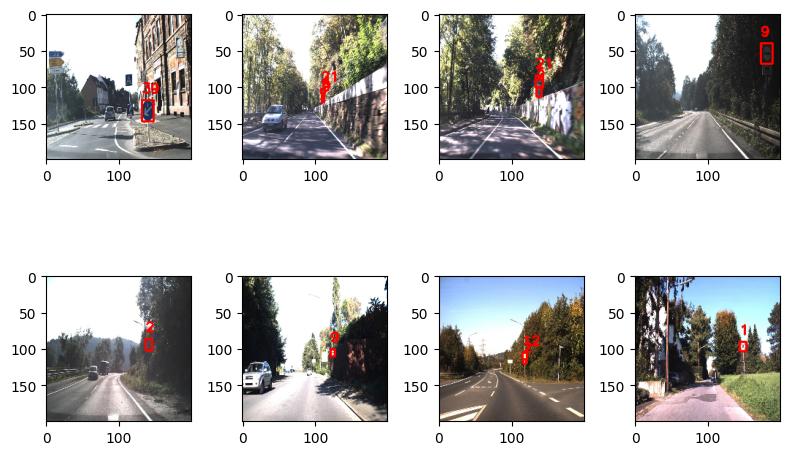

In [ ]:
plot_images_with_annotations(image_names, annotations_dir=r"G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\data\labels\train", input_shape=input_shape)

## **Erstellen einer Datensatz-Konfigurations-Datei im .yaml-Format in dem Projektverzeichnis**


In [2]:
dataset_configs = {
    'path': '/teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data',
    'train': '/teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/images/train',
    'val': '/teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/images/validation',
    'test': '/teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/images/test',
    'nc': 43,
    'names': [
        'Geschwindigkeitsbegrenzung (20 km/h)',
        'Geschwindigkeitsbegrenzung (30 km/h)',
        'Geschwindigkeitsbegrenzung (50 km/h)',
        'Geschwindigkeitsbegrenzung (60 km/h)',
        'Geschwindigkeitsbegrenzung (70 km/h)',
        'Geschwindigkeitsbegrenzung (80 km/h)',
        'Ende der Geschwindigkeitsbegrenzung (80 km/h)',
        'Geschwindigkeitsbegrenzung (100 km/h)',
        'Geschwindigkeitsbegrenzung (120 km/h)',
        'Ueberholverbot',
        'Ueberholverbot fuer Fahrzeuge ueber 3,5 Tonnen',
        'Vorfahrt an der Kreuzung',
        'Vorfahrtsstrasse',
        'Vorfahrt gewaehren',
        'Stop',
        'Keine Fahrzeuge',
        'Verbot fuer Fahrzeuge > 3,5 Tonnen',
        'Einfahrt verboten',
        'Allgemeine Vorsicht',
        'Gefaehrliche Kurve links',
        'Gefaehrliche Kurve rechts',
        'Doppelte Kurve',
        'Unebene Fahrbahn',
        'Rutschige Strasse',
        'Fahrbahnverengung rechts',
        'Baustelle',
        'Ampel',
        'Fussgaengerueberquerung',
        'Kinderueberquerung',
        'Radfahrerueberquerung',
        'Vorsicht vor Eis/Schnee',
        'Wildwechsel',
        'Ende von Geschwindigkeits- und Ueberholverboten',
        'Rechts abbiegen',
        'Links abbiegen',
        'Geradeaus',
        'Geradeaus oder rechts',
        'Geradeaus oder links',
        'Rechts halten',
        'Links halten',
        'Kreisverkehr Pflicht',
        'Ende des Ueberholverbots',
        'Ende des Ueberholverbots fuer Fahrzeuge > 3,5 Tonnen'
    ]
}

yaml_output = yaml.dump(dataset_configs, sort_keys=False)
print(yaml_output)
write_yaml_to_file(dataset_configs, 'dataset_lightningai')

path: /teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data
train: /teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/images/train
val: /teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/images/validation
test: /teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/images/test
nc: 43
names:
- Geschwindigkeitsbegrenzung (20 km/h)
- Geschwindigkeitsbegrenzung (30 km/h)
- Geschwindigkeitsbegrenzung (50 km/h)
- Geschwindigkeitsbegrenzung (60 km/h)
- Geschwindigkeitsbegrenzung (70 km/h)
- Geschwindigkeitsbegrenzung (80 km/h)
- Ende der Geschwindigkeitsbegrenzung (80 km/h)
- Geschwindigkeitsbegrenzung (100 km/h)
- Geschwindigkeitsbegrenzung (120 km/h)
- Ueberholverbot
- Ueberholverbot fuer Fahrzeuge ueber 3,5 Tonnen
- Vorfahrt an der Kreuzung
- Vorfahrtsstrasse
- Vorfahrt gewaehren
- Stop
- Keine Fahrzeuge
- Verbot fuer Fahrzeuge > 3,5 T

## **Schnittstelle zu WandB-Konto herstellen**

In [56]:
wandb.login(key="c1cb8293bb986e1a60106d41c29bde806ad72758")
WANDB_PROJECT='projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb'

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: laieb-ahmed (laieb-ahmed-fachhochschule-kiel). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\papa0\_netrc


## **Training des Modell (Cloud-GPU)**

In [57]:
model = YOLO("yolov5s.pt")
model.info()

%cd /content/drive/MyDrive/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb
!python /teamspace/studios/this_studio/yolov5/train.py --img-size 640 --batch 32 --epochs 100 --data /teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/dataset_lightningai.yaml --weights yolov5s.pt --cos-lr

PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:01<00:00, 12.7MB/s]


YOLOv5s summary: 262 layers, 9,153,152 parameters, 0 gradients, 24.2 GFLOPs
[WinError 3] Das System kann den angegebenen Pfad nicht finden: '/content/drive/MyDrive/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb'
g:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb


python: can't open file 'G:\\teamspace\\studios\\this_studio\\yolov5\\train.py': [Errno 2] No such file or directory


## **Validieren des Datensatzes anhand der trainierten Gewichtungen**

In [6]:
!python /teamspace/studios/this_studio/yolov5/val.py --weights /teamspace/studios/this_studio/yolov5/runs/train/exp/weights/best.pt --data /teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/dataset_lightningai.yaml --img-size 640 --iou 0.65 --task val --batch 32 --save-json --save-txt

val: data=/teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/data/dataset_lightningai.yaml, weights=['/teamspace/studios/this_studio/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=True, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 21022656 parameters, 0 gradients, 48.4 GFLOPs
val: Scanning /teamspace/studios/this_studio/projekt-cnn-yolo-echtzeiterkennung-
                 Class     Images  Instances          P          R      mAP50   
                   all        148        238      0.512      0.596      0.488      0.407
Geschwindigkeitsbegrenzung (30 km/h)        148         13       0.

## **Starten der Echtzeiterkennung**


In [ ]:
##Webcam
!python "G:/Meine Ablage/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/yolov5/detect.py" --weights "G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\yolov5\runs\train\1_trainingslauf_yolov5s_standard_batch_32_epoch_100_img_640\weights\best (1).pt" --data "G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\data\dataset_vscode.yaml" --source 1 --img-size 640 --augment

detect: weights=['G:\\Meine Ablage\\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\\yolov5\\runs\\train\\1_trainingslauf_yolov5s_standard_batch_32_epoch_100_img_640\\weights\\best (1).pt'], source=1, data=G:\Meine Ablage\projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb\data\dataset_vscode.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2024-10-11 Python-3.12.4 torch-2.4.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7126096 parameters, 0 gradients, 16.1 GFLOPs
1/1: 1...  Success (inf frames 640x480 at 30.00 FPS)

0: 480x640 (no detections), 478.1ms
0: 480x640 1 Vorfahrtsstrasse, 322.8ms
0: 480x640 (no


0: 480x640 (no detections), 347.0ms
0: 480x640 (no detections), 346.1ms
0: 480x640 (no detections), 343.8ms
0: 480x640 (no detections), 351.7ms
0: 480x640 (no detections), 316.8ms
0: 480x640 (no detections), 343.2ms
0: 480x640 1 Vorfahrtsstrasse, 344.7ms
0: 480x640 (no detections), 332.0ms
0: 480x640 (no detections), 323.8ms
0: 480x640 (no detections), 340.1ms
0: 480x640 (no detections), 353.2ms
0: 480x640 (no detections), 327.9ms
0: 480x640 (no detections), 358.1ms
0: 480x640 (no detections), 389.3ms
0: 480x640 (no detections), 358.1ms
0: 480x640 (no detections), 401.3ms
0: 480x640 (no detections), 440.8ms
0: 480x640 (no detections), 440.6ms
0: 480x640 (no detections), 332.2ms
0: 480x640 (no detections), 331.6ms
0: 480x640 (no detections), 339.1ms
0: 480x640 (no detections), 325.6ms
0: 480x640 (no detections), 326.0ms
0: 480x640 (no detections), 337.7ms
0: 480x640 (no detections), 354.6ms
0: 480x640 (no detections), 329.1ms
0: 480x640 (no detections), 321.1ms
0: 480x640 (no detection

## **Plots der Trainingsmetriken (..._loss, recall, mAP**)

In [39]:
import os
import matplotlib.pyplot as plt

%matplotlib inline

# Change to the correct directory
os.chdir('G:/Meine Ablage/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/yolov5')

# Check if the results.csv file exists
results_path = "G:/Meine Ablage/projekt-cnn-yolo-echtzeiterkennung-verkehszeichen-gtsrb/yolov5/runs/train/exp/results.csv"
if os.path.exists(results_path):
	from utils.plots import plot_results
	plot_results(results_path)
	plt.show()
else:
	print(f"No results.csv file found at {results_path}")